# 01 | Baseline Model  
*Train a simple logistic regression on the engineered data to establish a performance benchmark.*

In [85]:
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

## Load Engineered Dataset  
We’ll pull from our `credit_risk_engineered` table in the SQLite DB.

In [86]:
conn = sqlite3.connect("../data/loanvet.db")
df = pd.read_sql_query("SELECT * FROM credit_risk_engineered", conn)
conn.close()
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,...,TotalDelinquencies_log,HighUtilizationFlag,IncomePerCreditLine,AgeGroup_MidAge,AgeGroup_Senior,DependentsGroup_Small,DependentsGroup_Large,Util_x_Late,IncomePerDependent,CreditLines_x_Delinquencies
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,...,1.098612,0,651.428571,1,0,1,0,0.000000,3040.0,26
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,...,0.000000,1,520.000000,1,0,1,0,0.000000,1300.0,0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,...,1.098612,0,1014.000000,1,0,0,0,0.350539,3042.0,4
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,...,0.000000,0,550.000000,1,0,0,0,0.000000,3300.0,0
4,0,0.907239,49,1,0.024926,50000.0,7,0,1,0,...,0.693147,1,6250.000000,1,0,0,0,0.000000,50000.0,7


## Drop Redundant Columns

In [ ]:
drop_cols = [
    "RevolvingUtilizationOfUnsecuredLines",
    "DebtRatio",
    "NumberOfTime30-59DaysPastDueNotWorse",
    "NumberOfTimes90DaysLate",
    "NumberOfTime60-89DaysPastDueNotWorse",
    'NumberOfTime30-59DaysPastDueNotWorse_log',
    'NumberOfTimes90DaysLate_log',
    'NumberOfTime60-89DaysPastDueNotWorse_log',
    "age",
    "NumberOfDependents",
    "TotalDelinquencies",
    "MonthlyIncome_log"
]
df = df.drop(columns=drop_cols, errors="ignore")

## Train/Test Split
Stratify on the target to preserve imbalance.

In [88]:
X = df.drop(columns=["SeriousDlqin2yrs"])
y = df["SeriousDlqin2yrs"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

## Baseline Logistic Regression
Train with class weights to handle imbalance.

In [89]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(class_weight="balanced", max_iter=1000)
)

pipeline.fit(X_train, y_train)
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

## Performance Metrics  
Calculate ROC‑AUC and PR‑AUC.

In [90]:
roc_auc = roc_auc_score(y_test, y_pred_prob)
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)
print(f"ROC‑AUC: {roc_auc:.4f}, PR‑AUC: {pr_auc:.4f}")

ROC‑AUC: 0.8558, PR‑AUC: 0.3735


## Feature Importance (Coefficients)  
Examine which features carry the most weight.

In [91]:
logreg_model = pipeline.steps[-1][1]

coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coef": logreg_model.coef_[0]
})

coef_df = coef_df.assign(abs_coef=lambda d: d.coef.abs()).sort_values("abs_coef", ascending=False)

print(coef_df.head(10))


                                     feature      coef  abs_coef
7                     TotalDelinquencies_log  0.888535  0.888535
5   RevolvingUtilizationOfUnsecuredLines_log  0.728600  0.728600
11                           AgeGroup_Senior -0.376392  0.376392
1            NumberOfOpenCreditLinesAndLoans  0.247410  0.247410
0                              MonthlyIncome -0.243798  0.243798
10                           AgeGroup_MidAge -0.175826  0.175826
2               NumberRealEstateLoansOrLines  0.161555  0.161555
6                              DebtRatio_log -0.144261  0.144261
16               CreditLines_x_Delinquencies -0.135478  0.135478
9                        IncomePerCreditLine  0.122219  0.122219


## ROC & Precision‑Recall Curves


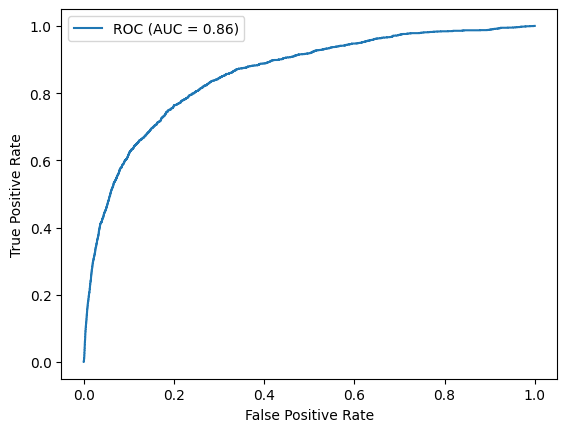

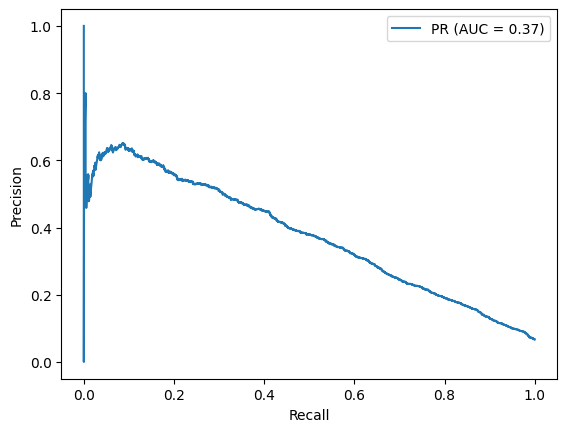

In [92]:
import matplotlib.pyplot as plt

# ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# PR curve
plt.plot(recall, precision, label=f"PR (AUC = {pr_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

## Conclusions  
- Baseline ROC‑AUC: 0.8558
- PR‑AUC: 0.3735